Esta notebook contiene bloques de código útiles para realizar Q-learning en el entorno "Pendulum"

In [2]:
import numpy as np
from pendulum_env_extended import PendulumEnvExtended
import random 
import pickle
import os

In [3]:
env = PendulumEnvExtended(render_mode='rgb_array')

Discretización de los estados

In [4]:
x_space = np.linspace(-1, 1, 15)
y_space = np.linspace(-1, 1, 15)
vel_space = np.linspace(-8, 8, 100)
x_space

array([-1.        , -0.85714286, -0.71428571, -0.57142857, -0.42857143,
       -0.28571429, -0.14285714,  0.        ,  0.14285714,  0.28571429,
        0.42857143,  0.57142857,  0.71428571,  0.85714286,  1.        ])

Obtener el estado a partir de la observación

In [5]:
def get_state(obs):
    x, y, vel = obs
    x_bin = np.digitize(x, x_space)
    y_bin = np.digitize(y, y_space)
    vel_bin = np.digitize(vel, vel_space)
    return x_bin, y_bin, vel_bin

In [6]:
state = get_state(np.array([-0.4, 0.2, 0.3]))
state

(5, 9, 52)

Discretización de las acciones

In [7]:
actions = list(np.linspace(-2, 2, 15))
actions

[-2.0,
 -1.7142857142857144,
 -1.4285714285714286,
 -1.1428571428571428,
 -0.8571428571428572,
 -0.5714285714285716,
 -0.2857142857142858,
 0.0,
 0.2857142857142856,
 0.5714285714285712,
 0.8571428571428568,
 1.1428571428571428,
 1.4285714285714284,
 1.714285714285714,
 2.0]

In [8]:
def get_sample_action():
    return random.choice(actions)

Inicilización de la tabla Q

In [9]:
Q = np.zeros((len(x_space) + 1, len(y_space) + 1, len(vel_space) + 1, len(actions)))
Q

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

Obtención de la acción a partir de la tabla Q

In [10]:
def optimal_policy(state, Q):
    action = np.argmax(Q[state[0]][state[1]][state[2]])
    return action

Epsilon-Greedy Policy

In [11]:
def epsilon_greedy_policy(state, Q, epsilon):
    explore = np.random.binomial(1, epsilon)
    if explore:
        action = actions.index(get_sample_action())
        #print('explore')
    # exploit
    else:
        action = np.argmax(Q[state[0]][state[1]][state[2]])
        #print('exploit')
        
    return action, explore


Encontrar una acción randómica entre buckets consecutivos

In [12]:
def get_random_action_by_index(actionIndex):
    if actionIndex == 0:
        action = random.uniform(-2.0, actions[actionIndex + 1])
    elif actionIndex == len(actions) - 1:
        action = random.uniform(actions[actionIndex - 1], 2.0)
    else:
        action = random.uniform(actions[actionIndex], actions[actionIndex + 1])
    return action

Devolver acción por índice

In [13]:
def get_action_by_index(actionIndex):
    action = actions[actionIndex]
    return action

Guardado de progreso

In [14]:
def save_progress(Q, total_rewards, episode):
    # Crear la carpeta 'progress' si no existe
    progress_dir = 'progress'
    os.makedirs(progress_dir, exist_ok=True)
    
    # Guardar el archivo de progreso en la carpeta 'progress'
    with open(os.path.join(progress_dir, f'progress_{episode}.pkl'), 'wb') as f:
        pickle.dump((Q, total_rewards), f)

Carga de progreso

In [15]:
def load_progress(filename):
    # Especificar la carpeta de progreso
    progress_dir = 'progress'
    filepath = os.path.join(progress_dir, filename)
    
    with open(filepath, 'rb') as f:
        return pickle.load(f)

Hiperparámetros

In [16]:
# Parámetros del algoritmo
num_episodes = 100000  # Número de episodios de entrenamiento
gamma = 0.99  # Factor de descuento

# Tasa de aprendizaje
alpha_start = 0.1
alpha_end = 0.01

# Probabilidad de exploración
epsilon_start = 0.9
epsilon_end = 0.1

# porcentaje significativo de mejora
threshold_percentage = 0.1  

Decrecimiento lineal de hiperparámetro

In [17]:
def linear_decay(episode, hyperparameter_start, hyperparameter_end, num_episodes):
    hyperparameter = max(hyperparameter_end, hyperparameter_start - (episode / num_episodes) * (hyperparameter_start - hyperparameter_end))
    return hyperparameter

Entrenamiento

In [18]:
def train(Q, epsilon, alpha, gamma):
    obs,_ = env.reset()
    done = False
    state = get_state(obs)
    while not done:     
        action_index, explore = epsilon_greedy_policy(state, Q, epsilon)
        if explore:
            action = get_action_by_index(action_index)
        else:
            action = get_action_by_index(action_index)
        next_state_index, reward, done, _, _ = env.step([action])
        next_state = get_state(next_state_index)
        old_value = Q[state[0]][state[1]][state[2]][action_index]
        next_max = np.max(Q[next_state[0]][next_state[1]][next_state[2]])

        new_value = old_value + alpha * (reward + gamma * next_max - old_value)
        # Si la nueva acción da mejor valor, actualizar actions
        #if explore and new_value > old_value*(1+threshold_percentage):
          #  actions[action_index] = action
        # Actualizar el valor Q
        Q[state[0]][state[1]][state[2]][action_index] = new_value
        

        state = next_state
        
        #obs, reward, done, _, _ = env.step([action])
        #print('->', state, action, reward, obs, done)
        

Test

In [19]:
def test(Q, total_rewards):
    obs,_ = env.reset()
    #print(obs)
    done = False
    total_reward = 0
    while not done:
        state = get_state(obs)
        action_index = optimal_policy(state, Q)
        action = actions[action_index]
        obs, reward, done, _, _ = env.step([action])
        total_reward += reward
        #print('->', state, action, reward, obs, done)
    total_rewards.append(total_reward)

Graficado

In [20]:
import matplotlib.pyplot as plt

def plot_rewards(total_rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(total_rewards)), total_rewards, marker='o', linestyle='-', color='b')
    plt.xlabel('Episodios')
    plt.ylabel('Recompensas')
    plt.title('Recompensas Totales en Función de los Episodios')
    plt.grid(True)
    plt.show()


Ejemplo de episodio 

In [39]:
import gc
# Inicializar variables
total_rewards = []
save_interval = 5000  # Guardar el progreso cada 5000 episodios

# Cargar progreso si existe
start_episode = 0
try:
    Q, total_rewards = load_progress('progress_.pkl')
    start_episode = len(total_rewards)
except FileNotFoundError:
    pass

# Entrenamiento y test
for episode in range(start_episode, num_episodes):
    # Calcular epsilon para el episodio actual
    epsilon = linear_decay(episode, epsilon_start, epsilon_end, num_episodes)
    alpha = linear_decay(episode, alpha_start, alpha_end, num_episodes)
    
    train(Q, epsilon, alpha, gamma)
    test(Q, total_rewards)
    
    # Guardar progreso periódicamente
    if episode % save_interval == 0:
        save_progress(Q, total_rewards, episode)
        
    # Limpiar memoria
    gc.collect()
# Resultados
save_progress(Q, total_rewards, num_episodes)  # Guardar el progreso final


Recompensas: [-4521.403133837075, -5400.408051282831, -3795.923174832526, -3847.9775738080193, -4448.473918623619, -4958.160375830459, -3927.099065231986, -5792.823894405394, -5795.589523486633, -3984.887836801149, -5445.373932447761, -5557.219853355555, -3313.831995532779, -5302.267471300615, -5617.739314913491, -3774.3977482068794, -4954.46255413905, -5552.973791026162, -5747.326389406989, -3980.281373047425, -5510.651957419076, -5787.875561477269, -4922.724958109145, -3982.6473356270794, -3861.7027757244696, -5506.720982968762, -5523.771779618915, -5389.044022547623, -3972.164035480885, -4001.592787428588, -5405.062646786027, -5108.860305949623, -4183.480366584528, -5055.884584642713, -4163.357451694173, -4879.868422941798, -5206.393844899378, -4826.38799922558, -5145.626902397515, -5017.714973076647, -5243.056532140389, -4828.953014294007, -3994.9911842106653, -5449.896613215763, -4729.910059697556, -5451.856661301794, -4461.820508652975, -3738.4892283903673, -5369.122912626823, -4

Recompensas

In [21]:
try:
    Q100k, total_rewards_100k = load_progress('progress_100000.pkl')
except FileNotFoundError:
    print("No se ha encontrado el archivo 'progress_100000.pkl'")

print("Recompensas:", total_rewards_100k)
print("Recompensas promedio:", np.mean(total_rewards_100k))
print("Mínima recompensa:", np.min(total_rewards_100k))
print("Máxima recompensa:", np.max(total_rewards_100k))

Recompensas: [-4521.403133837075, -5400.408051282831, -3795.923174832526, -3847.9775738080193, -4448.473918623619, -4958.160375830459, -3927.099065231986, -5792.823894405394, -5795.589523486633, -3984.887836801149, -5445.373932447761, -5557.219853355555, -3313.831995532779, -5302.267471300615, -5617.739314913491, -3774.3977482068794, -4954.46255413905, -5552.973791026162, -5747.326389406989, -3980.281373047425, -5510.651957419076, -5787.875561477269, -4922.724958109145, -3982.6473356270794, -3861.7027757244696, -5506.720982968762, -5523.771779618915, -5389.044022547623, -3972.164035480885, -4001.592787428588, -5405.062646786027, -5108.860305949623, -4183.480366584528, -5055.884584642713, -4163.357451694173, -4879.868422941798, -5206.393844899378, -4826.38799922558, -5145.626902397515, -5017.714973076647, -5243.056532140389, -4828.953014294007, -3994.9911842106653, -5449.896613215763, -4729.910059697556, -5451.856661301794, -4461.820508652975, -3738.4892283903673, -5369.122912626823, -4

Aprendizaje luego de 30 mil episodios de entrenamiento

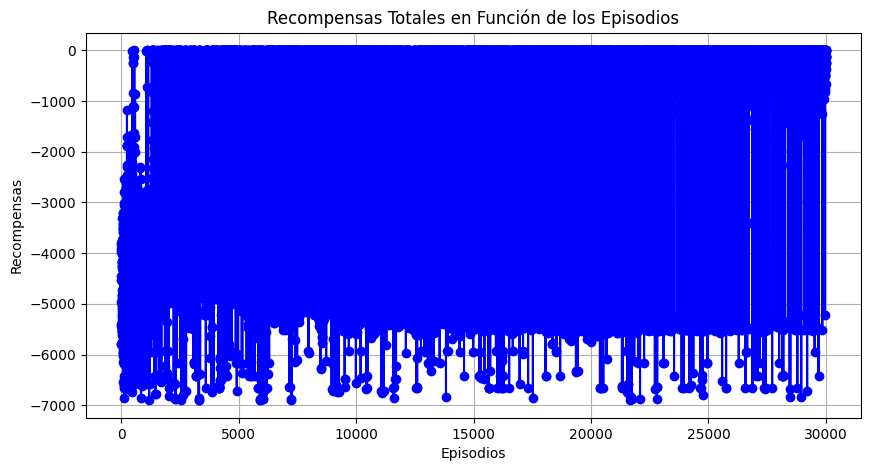

In [40]:
try:
    Q30k, total_rewards_30k = load_progress('progress_30000.pkl')
except FileNotFoundError:
    print("No se ha encontrado el archivo 'progress_30000.pkl'")

plot_rewards(total_rewards_30k) 


Aprendizaje luego de 60 mil episodios de entrenamiento

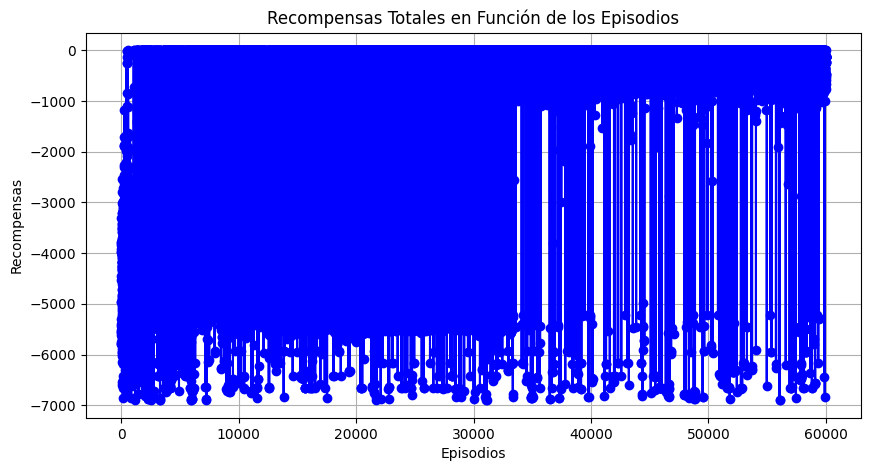

In [41]:
try:
    Q60k, total_rewards_60k = load_progress('progress_60000.pkl')
except FileNotFoundError:
    print("No se ha encontrado el archivo 'progress_60000.pkl'")

plot_rewards(total_rewards_60k) 

Aprendizaje luego de 100 mil episodios de entrenamiento

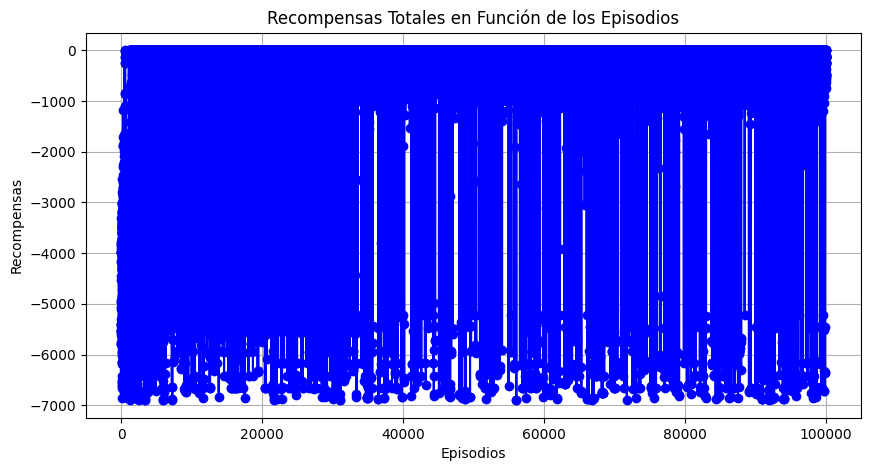

In [42]:
plot_rewards(total_rewards_100k) 

Graficando las rewards acumuladas de los ultimos 1000 episodios

Recompensas: [-2.8967850736553964, -124.70209017865271, -2.621761138994777, -2.1723397998048424, -3.247026222906915, -124.46391349295652, -129.68220835652207, -127.31062893027057, -122.06667002658752, -238.3723460056724, -237.94023200288376, -126.39267877935359, -356.2187435711102, -124.79764929726014, -127.55669843919932, -130.12658432986044, -123.46870119924687, -248.58234862430248, -817.4009544776972, -124.59816876529527, -4.802319661781213, -131.04345949424697, -242.4270889822905, -135.59876046623825, -130.71688524729402, -129.38215678482914, -126.29708171213777, -129.63160442550537, -521.3302391856729, -128.04016996875265, -124.1462446294416, -123.13900361292386, -126.00117219521232, -116.22108690142058, -125.36040043162733, -120.76226570842451, -124.18874981807883, -128.1209483427338, -129.7628541402483, -128.12360063713479, -2.8328256013130484, -130.29114970819262, -120.08276974030838, -124.48301218952155, -249.72823744775442, -122.90750006217806, -3.6499395108124824, -379.30607

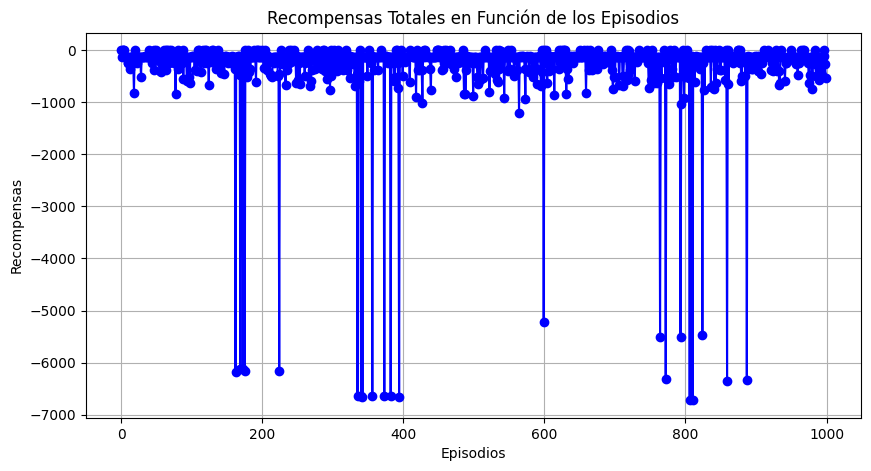

In [43]:
last_1000_rewards = total_rewards[-1000:]
print("Recompensas:", last_1000_rewards)
print("Recompensas promedio:", np.mean(last_1000_rewards))
print("Mínima recompensa:", np.min(last_1000_rewards))
print("Máxima recompensa:", np.max(last_1000_rewards))
plot_rewards(last_1000_rewards) 

Imprimir graficas de recompensas medias

In [25]:
def calcular_medias_por_grupos(array, tamano_grupo=1000):
    # Calcular cuántos grupos completos de 1000 elementos tendremos
    num_grupos = len(array) // tamano_grupo
    
    # Crear una lista para almacenar las medias
    medias = []
    
    # Calcular la media para cada grupo y almacenarla
    for i in range(num_grupos):
        inicio = i * tamano_grupo
        fin = (i + 1) * tamano_grupo
        grupo = array[inicio:fin]
        media = sum(grupo) / tamano_grupo
        medias.append(media)
    
    return medias

In [26]:
import matplotlib.pyplot as plt

def plot_mean_rewards(total_rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(total_rewards)), total_rewards, marker='o', linestyle='-', color='b')
    plt.xlabel('Episodiosx1000')
    plt.ylabel('Promedio de recompensas')
    plt.title('Promedio de Recompensas Cada 1000 Episodios')
    plt.grid(True)
    plt.show()

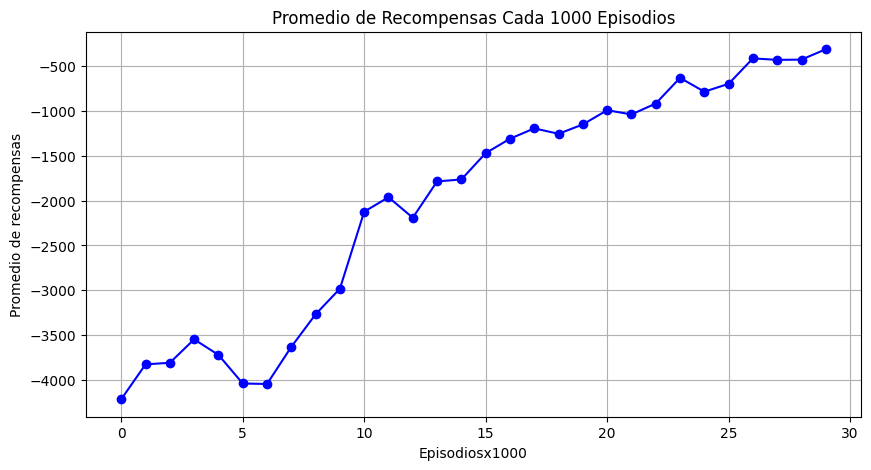

In [29]:
try:
    Q30k, total_rewards_30k = load_progress('progress_30000.pkl')
except FileNotFoundError:
    print("No se ha encontrado el archivo 'progress_30000.pkl'")
mean_rewards = calcular_medias_por_grupos(total_rewards_30k, 1000)
plot_mean_rewards(mean_rewards) 

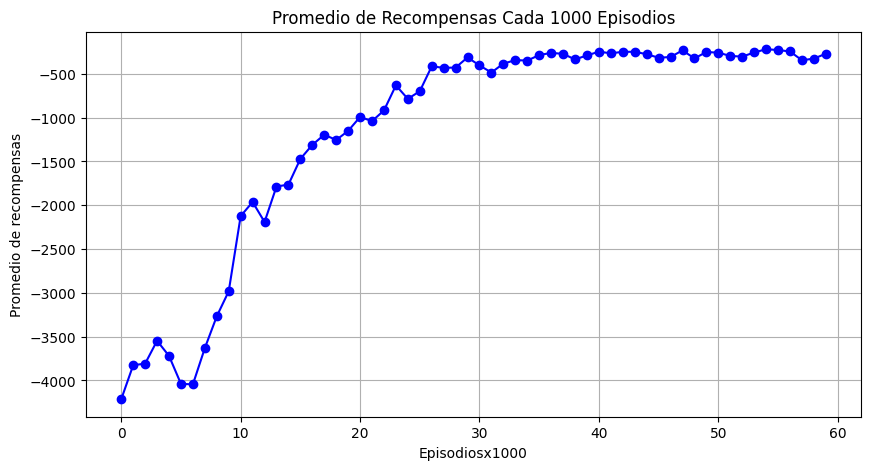

In [30]:
try:
    Q60k, total_rewards_60k = load_progress('progress_60000.pkl')
except FileNotFoundError:
    print("No se ha encontrado el archivo 'progress_60000.pkl'")
mean_rewards = calcular_medias_por_grupos(total_rewards_60k, 1000)
plot_mean_rewards(mean_rewards) 

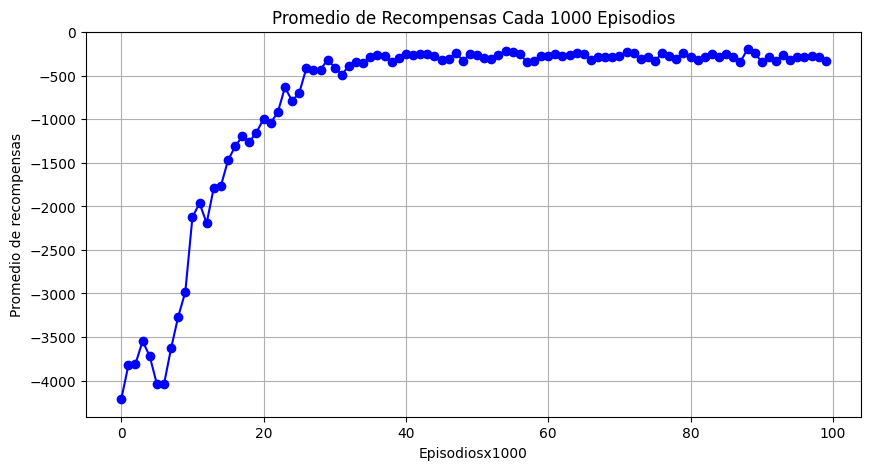

In [31]:
try:
    Q100k, total_rewards_100k = load_progress('progress_100000.pkl')
except FileNotFoundError:
    print("No se ha encontrado el archivo 'progress_100000.pkl'")
mean_rewards = calcular_medias_por_grupos(total_rewards_100k, 1000)
plot_mean_rewards(mean_rewards) 

# Visualización de juego

### Imports

In [28]:
import glob
import io
import base64
import gymnasium

from gymnasium.wrappers.record_video import RecordVideo
from IPython.display import HTML
from IPython import display as ipythondisplay

### Código para grabar video

In [29]:
def show_video():
    """
    Utility function to enable video recording of gym environment and displaying it
    To enable video, just do "env = wrap_env(env)""
    """
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
     
def wrap_env(env, name="default"):
    """
    Wrapper del ambiente donde definimos un Monitor que guarda la visualizacion como un archivo de video.
    """
    env = RecordVideo(env, "./video/", name_prefix=name, episode_trigger=lambda x: x % 2 == 0)
    return env

### Se crea el ambiente

In [30]:
ENV_NAME = "Pendulum-v1"
env = wrap_env(gymnasium.make(ENV_NAME, render_mode="rgb_array"))

Q, total_rewards = load_progress('progress_100000.pkl')

C:\Users\emili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gymnasium\wrappers\record_video.py:87: UserWarning: WARN: Overwriting existing videos at c:\Users\emili\Documentos\ORT\Semestre 7\IA\ObligatorioIA\Pendulum\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### Se crea el agente

In [31]:
class PendulumAgent:
    def __init__(self, env):
        self.env = env
    
    def select_action(self, state):
        action_index = optimal_policy(state, Q)
        action = actions[action_index]
        print('->', state, action)
        return action
    
    
    
agent = PendulumAgent(env)

### Hacemos la corrida y grabamos

In [32]:
acumulated_reward = 0
observation,_ = env.reset()
while True:
    env.render()
    state = get_state(observation)
    action = agent.select_action(state)
    observation, reward, done, truncated, _ = env.step([action])
    acumulated_reward += reward
    if done or truncated:
      break

print(f"Acumulated reward: {acumulated_reward}")

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

del env

-> (12, 2, 55) 2.0
-> (12, 2, 53) 1.4285714285714284
-> (12, 2, 51) 1.1428571428571428
-> (12, 2, 49) 1.4285714285714284
-> (12, 2, 47) 2.0
-> (12, 2, 45) 2.0
-> (12, 2, 43) 2.0
-> (11, 2, 41) 0.2857142857142856
-> (11, 1, 38) 1.714285714285714
-> (10, 1, 35) 0.8571428571428568
-> (9, 1, 31) 1.714285714285714
-> (8, 1, 28) 0.5714285714285712
-> (6, 1, 24) 0.5714285714285712
-> (4, 1, 20) -2.0
-> (3, 2, 14) -2.0
-> (1, 4, 9) -1.7142857142857144
-> (1, 7, 5) -0.2857142857142858
-> (1, 9, 4) -1.1428571428571428
-> (2, 11, 4) -1.1428571428571428
-> (3, 13, 6) 0.2857142857142856
-> (6, 14, 10) 0.5714285714285712
-> (7, 14, 15) 0.0
-> (9, 14, 19) 1.1428571428571428
-> (11, 14, 25) -2.0
-> (12, 13, 27) 0.8571428571428568
-> (12, 12, 32) -0.5714285714285716
-> (13, 12, 35) -2.0
-> (13, 11, 36) 2.0
-> (14, 11, 40) 0.5714285714285712
-> (14, 10, 43) 2.0
-> (14, 10, 46) 0.0
-> (14, 10, 48) -1.7142857142857144
-> (14, 10, 48) -1.7142857142857144
-> (14, 10, 48) -1.7142857142857144
-> (14, 10, 48) 

Moviepy - Done !
Moviepy - video ready c:\Users\emili\Documentos\ORT\Semestre 7\IA\ObligatorioIA\Pendulum\video\default-episode-0.mp4
Acumulated reward: -127.29516207146992
